In [1]:
import time
import copy
import torch
from torch import optim, nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.models import resnet50
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import sys
sys.path.append("..")
from IPython import display
from tqdm import tqdm
import warnings
import math
warnings.filterwarnings("ignore") # 忽略警告

In [8]:
 #标签中每个RGB颜色的值
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# 标签其标注的类别
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']


def read_voc_images(root="Data/VOCdevkit/VOC2012", is_train=True, max_num=None):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()  # 拆分成一个个名字组成list
    if max_num is not None:
        images = images[:min(max_num, len(images))]
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in tqdm(enumerate(images)):
        # 读入数据并且转为RGB的 PIL image
        features[i] = Image.open('%s/JPEGImages/%s.jpg' % (root, fname)).convert("RGB")
        labels[i] = Image.open('%s/SegmentationClass/%s.png' % (root, fname)).convert("RGB")
    return features, labels  # PIL image 0-255


def show_images(imgs, num_rows, num_cols, scale=2):
    # a_img = np.asarray(imgs)
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    plt.show()
    return axes


# 构造标签矩阵
def voc_label_indices(colormap, colormap2label):
    colormap = np.array(colormap.convert("RGB")).astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    return colormap2label[idx]  # colormap 映射 到colormaplabel中计算的下标


colormap2label = torch.zeros(256 ** 3, dtype=torch.uint8)  # torch.Size([16777216])
for i, colormap in enumerate(VOC_COLORMAP):
    # 每个通道的进制是256，这样可以保证每个 rgb 对应一个下标 i
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i


def voc_rand_crop(feature, label, height, width):
    """
    随机裁剪feature(PIL image) 和 label(PIL image).
    为了使裁剪的区域相同，不能直接使用RandomCrop，而要像下面这样做
    Get parameters for ``crop`` for a random crop.
    Args:
        img (PIL Image): Image to be cropped.
        output_size (tuple): Expected output size of the crop.
    Returns:
        tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
    """
    i, j, h, w = torchvision.transforms.RandomCrop.get_params(feature, output_size=(height, width))
    feature = torchvision.transforms.functional.crop(feature, i, j, h, w)
    label = torchvision.transforms.functional.crop(label, i, j, h, w)
    return feature, label


def voc_label_indices(colormap, colormap2label):
    colormap = np.array(colormap.convert("RGB")).astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    return colormap2label[idx]  # colormap 映射 到colormaplabel中计算的下标

    # 构建colormap2label



class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label, max_num=None):
        """
        crop_size: (h, w)
        """
        # 对输入图像的RGB三个通道的值分别做标准化
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.tsf = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=self.rgb_mean, std=self.rgb_std)])
        self.crop_size = crop_size  # (h, w)
        # 读取图像
        features, labels = read_voc_images(root=voc_dir, is_train=is_train, max_num=max_num)
        # 由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本需要通过自定义的filter函数所移除
        self.features = self.filter(features)  # PIL image
        self.labels = self.filter(labels)  # PIL image

        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' valid examples')

    def filter(self, imgs):
        return [img for img in imgs if (
                img.size[1] >= self.crop_size[0] and img.size[0] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
        # float32 tensor           uint8 tensor (b,h,w)
        return (self.tsf(feature), voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)
    
    
#构建colormap2label
colormap2label = torch.zeros(256**3, dtype=torch.uint8) # torch.Size([16777216])
for i, colormap in enumerate(VOC_COLORMAP):
    # 每个通道的进制是256，这样可以保证每个 rgb 对应一个下标 i
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# 根据自己存放数据集的路径修改voc_dir
voc_dir = r"..\..\Data\VOCdevkit\VOC2012"
train_features, train_labels = read_voc_images(voc_dir, max_num=10)
imgs = train_features[0:n] + train_labels[0:n] # PIL image
colormap2label = torch.zeros(256**3, dtype=torch.uint8) # torch.Size([16777216])
for i, colormap in enumerate(VOC_COLORMAP):
    # 每个通道的进制是256，这样可以保证每个 rgb 对应一个下标 i
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# 构造标签矩阵 : 功能是：通过[r,g,b]找到类别编号
#colormap:[128,0,0]
#colormap2label[0,0,0,.....,1,0,...2...]
def voc_label_indices(colormap, colormap2label):
    colormap = np.array(colormap.convert("RGB")).astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2]) 
    return colormap2label[idx] # colormap 映射 到colormaplabel中计算的下标

10it [00:00, 454.54it/s]


NameError: name 'n' is not defined

In [7]:
batch_size = 5 
crop_size = (320, 480) # 指定随机裁剪的输出图像的形状为(320,480)
max_num = 20000 # 最多从本地读多少张图片，（320,480)指定的这个尺寸过滤完不合适的图像之后只有1175张

# 创建训练集和测试集的实例
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label, max_num)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label, max_num)

# 设批量大小为32，分别定义【训练集】和【测试集】的数据迭代器
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                              drop_last=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(voc_test, batch_size, drop_last=True,
                             num_workers=num_workers)

# 方便封装，把训练集和验证集保存在dict里
dataloaders = {'train':train_iter, 'val':test_iter}
dataset_sizes = {'train':len(voc_train), 'val':len(voc_test)}

1464it [00:03, 424.31it/s]


read 1114 valid examples


1449it [00:03, 424.64it/s]

read 1078 valid examples


In [25]:
# 模型
class Hypercolumn(nn.Module):
    def __init__(self, num_classes, slic, target_num_features=256):
        super(Hypercolumn, self).__init__()

        self.device6 = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

        # 加载预训练的ResNet-50模型
        self.resnet = resnet50(pretrained=True)

        # 多头注意力
        self.attention = nn.MultiheadAttention(embed_dim=target_num_features, num_heads=2)

        # 冻结部分参数

        self.feature_map1 = nn.Sequential(*list(self.resnet.children())[:5])
        self.feature_map2 = nn.Sequential(*list(self.resnet.children())[5:6])
        self.feature_map3 = nn.Sequential(*list(self.resnet.children())[6:7])
        self.feature_map4 = nn.Sequential(*list(self.resnet.children())[7:-2])
        for param in self.feature_map1.parameters():
            param.requires_grad = False
        for param in self.feature_map2.parameters():
            param.requires_grad = False
        for param in self.feature_map3.parameters():
            param.requires_grad = False
        for param in self.feature_map4.parameters():
            param.requires_grad = False
    

        # 提取特征
        self.feature_map0 = nn.Conv2d(3, target_num_features, kernel_size=1)
        
        self.layer1 = nn.Sequential(*list(self.resnet.children())[:3], 
              nn.Conv2d(64,target_num_features,kernel_size=1), 
              nn.BatchNorm2d(target_num_features),
              nn.ReLU(),
              nn.ConvTranspose2d(target_num_features,target_num_features, kernel_size=4, stride=2, padding=1)) 
        
        self.layer2 = nn.Sequential(*list(self.resnet.children())[:6], 
              nn.Conv2d(512,target_num_features,kernel_size=1), 
              nn.BatchNorm2d(target_num_features),
              nn.ReLU(),
              nn.ConvTranspose2d(target_num_features,target_num_features, kernel_size=16, stride=8, padding=4)) 
        
        self.layer3 = nn.Sequential(*list(self.resnet.children())[:8], 
              nn.Conv2d(2048,target_num_features,kernel_size=1), 
              nn.BatchNorm2d(target_num_features),
              nn.ReLU(),
              nn.ConvTranspose2d(target_num_features,target_num_features, kernel_size=64, stride=32, padding=16)) 

        # 降维卷积
        self.reduce_dim =  nn.Sequential(nn.Conv2d(target_num_features * 4, target_num_features, kernel_size=1),
                                         nn.BatchNorm2d(target_num_features),
                                         nn.ReLU())
        
        #超像素分割
        self.slic = slic.to('cpu')

        # 分类层_SelfAttention
        self.attention = nn.MultiheadAttention(embed_dim=target_num_features, num_heads=2)

        # 分类层_FC
        self.classifer = nn.Sequential(nn.BatchNorm2d(target_num_features),
                                       nn.ReLU(), 
                                       nn.Conv2d(target_num_features, num_classes, kernel_size=1),
                                       nn.BatchNorm2d(num_classes),
                                       nn.ReLU(), 
                                       nn.Conv2d(num_classes, num_classes, kernel_size=1))
        

        #初始化：
        nn.init.xavier_normal_(self.layer1[-4].weight.data, gain=1)
        self.layer1[-1].weight.data = self.bilinear_kernel(target_num_features, target_num_features, 4)
        nn.init.xavier_normal_(self.layer2[-4].weight.data, gain=1)
        self.layer2[-1].weight.data = self.bilinear_kernel(target_num_features, target_num_features, 16)
        nn.init.xavier_normal_(self.layer3[-4].weight.data, gain=1)
        self.layer3[-1].weight.data = self.bilinear_kernel(target_num_features, target_num_features, 64)
    

    def forward(self, x):
        # 提取不同尺度的特征图
        height = x.size(2)
        width = x.size(3)
        super_height = height/3
        super_width = width/3
        batchsize = x.size(0)
        device6 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        feature0 = self.feature_map0(x)
        upsampled_feature1 = F.interpolate(self.layer1(x), size=(height, width), mode='bilinear', align_corners=False)
        upsampled_feature3 = F.interpolate(self.layer2(x), size=(height, width), mode='bilinear', align_corners=False)
        upsampled_feature5 = F.interpolate(self.layer3(x), size=(height, width), mode='bilinear', align_corners=False)
        # 将不同尺度的特征连接在一起
        hypercolumn = torch.cat([feature0, upsampled_feature1, upsampled_feature3, upsampled_feature5], dim=1)
        

        # 降维(batch_size,features,height,width)
        hypercolumn = self.reduce_dim(hypercolumn).to('cpu')
    
        #分割超像素
        hypercolumn_superpixel, Score  =  self.slic.ssn_iter(hypercolumn, int(super_height * super_width), 5)


        # 调整形状以满足 MultiheadAttention 的要求
        #hypercolumn_superpixel = hypercolumn_superpixel.view(hypercolumn_superpixel.size(0), hypercolumn_superpixel.size(1), -1)
        #hypercolumn_superpixel = hypercolumn_superpixel.permute(2, 0, 1)  # 将特征维度置于前面

        #多头注意力
        #attention_output, _ = self.attention(hypercolumn_superpixel, hypercolumn_superpixel, hypercolumn_superpixel)
        #del hypercolumn_superpixel

        #恢复形状
        #attention_output = attention_output.permute(1, 2, 0)
        #attention_output = attention_output.reshape(attention_output.size(0),attention_output.size(1),height,-1)

        # 多头注意力分类层
        hypercolumn_superpixel_class = self.classifer(hypercolumn_superpixel.to(device6).reshape(hypercolumn_superpixel.size(0),hypercolumn_superpixel.size(1),int(super_height),int(super_width)))

        # 分类层
        #hypercolumn_superpixel_class = self.classifier(attention_output.reshape(batchsize,target_num_features,int(super_height),int(super_width)).cuda())
        #hypercolumn_superpixel_class:(5,21,30,45)

        #hypercolumn_superpixel_class = self.classifier(attention_output)

        #映射层
        output = torch.bmm(hypercolumn_superpixel_class.reshape(batchsize,21,int(super_height * super_width)), Score.to(device6)).reshape(batchsize,21,height,width)

        return output
    

     # 模型初始化
     # 双线性插值的上采样，用来初始化转置卷积层的卷积核
    def bilinear_kernel(self, in_channels, out_channels, kernel_size):
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
        weight[range(in_channels), range(out_channels), :, :] = filt
        weight = torch.Tensor(weight)
        weight.requires_grad = True
        return weight

In [26]:
import torch
import torch.nn as nn
import math

class SILC(nn.Module):

    # (num_spixels = 54 * 54 )  h = w = 4
    def ssn_iter(self, pixel_features, num_spixels, n_iter):

        permute_pixel_features = pixel_features.reshape(pixel_features.size(0), pixel_features.size(1), -1)
        height, width = pixel_features.shape[-2:]
        num_spixels_width = int(math.sqrt(num_spixels * width / height))
        num_spixels_height = int(math.sqrt(num_spixels * height / width))

        # 1.初始化Spixels（S0）[batch_size, ___ , h*w ]
        spixel_features, init_label_map = self.calc_init_centroid(pixel_features, num_spixels_width, num_spixels_height)

        # 2.注意力机制求出Q_0，K_0，V_0
        pixels_Q, pixels_K, pixels_V = self.SelfAttenion(permute_pixel_features)
        spixels_Q, spixels_K, spixels_V = self.SelfAttenion(spixel_features)

        # Mask 矩阵 : 用来屏蔽这些不在范围内的值
        mask_array = self.get_mask_all(num_spixels_width, num_spixels, init_label_map)

        # 3更新Spixels和Pixels（）
        for _ in range(n_iter):
            # 计算得分Score_Superpixel，Score_pixel
            Score_Superpixel = torch.matmul(spixels_Q, pixels_K.permute(0, 2, 1)) / (spixels_Q.size(-1) ** 0.5)
            Score_pixel = torch.matmul(pixels_Q, spixels_K.permute(0, 2, 1)) / (pixels_Q.size(-1) ** 0.5)

            # 屏蔽不在范围内的值
            Score_Superpixel = Score_Superpixel * mask_array
            Score_pixel = Score_pixel * mask_array.T

            # 0 值换成 最大值
            max_value = 1e16
            Score_Superpixel = torch.where(Score_Superpixel == 0, max_value, Score_Superpixel)
            Score_pixel = torch.where(Score_pixel == 0, max_value, Score_pixel)

            # softmax化
            Score_Superpixel = (-Score_Superpixel).softmax(2)
            Score_pixel = (-Score_pixel).softmax(2)

            Add_spixel_features = torch.bmm(Score_Superpixel, pixels_V)
            Add_pixel_features = torch.bmm(Score_pixel, spixels_V)

            # 更新： I(i+1) = I(i) + softmax（q_I(i) * k_S(i)）* V_S(i)
            spixel_features = spixel_features.permute(0, 2, 1)
            spixel_features = spixel_features + Add_spixel_features
            spixel_features = spixel_features.permute(0, 2, 1)

            permute_pixel_features = permute_pixel_features.permute(0, 2, 1)
            permute_pixel_features = permute_pixel_features + Add_pixel_features
            permute_pixel_features = permute_pixel_features.permute(0, 2, 1)

            pixels_Q, pixels_K, pixels_V = self.SelfAttenion(permute_pixel_features)
            spixels_Q, spixels_K, spixels_V = self.SelfAttenion(spixel_features)

        # 最终权重矩阵Q的返回：
        Score = torch.bmm(spixel_features.permute(0,2,1), permute_pixel_features) / (spixel_features.size(1) ** 0.5)
        Score = Score_Superpixel = Score_Superpixel * mask_array
        max_value = 1e16
        Score = torch.where(Score_Superpixel == 0, max_value, Score_Superpixel)
        # Score:[batch_size, Spixel_num, Pixel_num]
        Score = (-Score).softmax(2)

        return spixel_features, Score

    # batch * features * numpixels（224 * 224）
    def SelfAttenion(self, pixel_features):
        # 256
        input_dim = pixel_features.size(1)
        # 224 * 224
        num_pixel = pixel_features.size(2)
        # 【batch * numpixels（224 * 224），features】
        reshaped_input = pixel_features.reshape(pixel_features.size(0) * pixel_features.size(2), -1)
        # 初始化转换矩阵
        self.linear_q = nn.Linear(input_dim, input_dim)
        self.linear_k = nn.Linear(input_dim, input_dim)
        self.linear_v = nn.Linear(input_dim, input_dim)
        # 计算 Q 矩阵
        Q = self.linear_q(reshaped_input)
        # 计算 K 矩阵
        K = self.linear_k(reshaped_input)
        # 计算 V 矩阵
        V = self.linear_v(reshaped_input)
        # 重塑回原形：(batch, 256, 224 * 224)
        Q = Q.view(pixel_features.size())
        K = K.view(pixel_features.size())
        V = V.view(pixel_features.size())

        # 位置编码
        # self.position_embedding = nn.Parameter(torch.randn(1 ,num_pixel, input_dim))
        # 添加位置编码
        # Q += self.position_embedding.unsqueeze(0)
        # K += self.position_embedding.unsqueeze(0)
        # V += self.position_embedding.unsqueeze(0)

        Q = Q.permute(0, 2, 1)
        K = K.permute(0, 2, 1)
        V = V.permute(0, 2, 1)
        return Q, K, V

    # 初始化SupwerPixel
    # 输入[batch, features, size_h, size_w]
    def calc_init_centroid(self, images, num_spixels_width, num_spixels_height):
        # images: torch.Tensor(B, C, H, W)
        batchsize, channels, height, width = images.shape
        device = images.device
        # 返回一组向量（B,C，num_spixels_height, num_spixels_width）
        centroids = torch.nn.functional.adaptive_avg_pool2d(images, (num_spixels_height, num_spixels_width))

        with torch.no_grad():
            num_spixels = num_spixels_width * num_spixels_height
            # 创建一个Label Tensor 【1,1，s_h, s_w】
            labels = torch.arange(num_spixels, device=device).reshape(1, 1, *centroids.shape[-2:]).type_as(centroids)
            # 扩成一个label Tensor 【1,1，h, w】
            init_label_map = torch.nn.functional.interpolate(labels, size=(height, width), mode="nearest")
            # 扩成一个label Tensor 【batch_size,1，h, w】
            init_label_map = init_label_map.repeat(batchsize, 1, 1, 1)

        # 统一修改尺寸[batch_size, ___ , h*w ]  举例忽视batch值
        init_label_map = init_label_map.reshape(batchsize, -1)  # -》 map[1] 表示 第一个pixel 所属的 SuperPixel
        centroids = centroids.reshape(batchsize, channels, -1)

        return centroids, init_label_map

        # 根据get_mask_one算掩码矩阵

    def get_mask_all(self, num_width, spixel_num, init_label_map):
        mask_array_list = []
        for spixel_id in range(spixel_num):
            t = self.get_mask_one(spixel_id, num_width, spixel_num, init_label_map[0])
            mask_array_list.append(t)
        mask_array = torch.cat(mask_array_list).reshape(spixel_num, -1)
        return mask_array

    # 根据对应的中心点算掩码, 例如SuperPixel[1]对应的超像素掩码
    def get_mask_one(self, superpixel_id, num_width, spixel_num, init_label_map):
        superpixel_id_set = self.get_superpixel_id_set(superpixel_id, num_width, spixel_num)
        boolean_mask = init_label_map.eq(torch.tensor(list(superpixel_id_set)).view(-1, 1))
        mask_array = boolean_mask.any(dim=0).int().numpy()
        return torch.tensor(mask_array)

    # 获取相邻的超像素点集合：
    # 输出 list[]
    def get_superpixel_id_set(self, superpixel_id, num_width, spixel_num):
        superpixel_id_set = []
        superpixel_id_set.append(superpixel_id)
        # 最左边
        if superpixel_id % num_width == 0:
            # 最上面
            if superpixel_id <= num_width - 1:
                # 加入 下面、右边
                superpixel_id_set.append(superpixel_id + 1)
                superpixel_id_set.append(superpixel_id + num_width)
                superpixel_id_set.append(superpixel_id + num_width + 1)

            # 最下面
            elif superpixel_id >= (spixel_num - num_width - 1):
                superpixel_id_set.append(superpixel_id + 1)
                superpixel_id_set.append(superpixel_id - num_width)
                superpixel_id_set.append(superpixel_id - num_width + 1)

            else:
                superpixel_id_set.append(superpixel_id + 1)
                superpixel_id_set.append(superpixel_id + num_width)
                superpixel_id_set.append(superpixel_id + num_width + 1)
                superpixel_id_set.append(superpixel_id - num_width)
                superpixel_id_set.append(superpixel_id - num_width + 1)

        # 最右边
        elif superpixel_id % num_width == (num_width - 1):
            # 最上面
            if superpixel_id <= num_width - 1:
                superpixel_id_set.append(superpixel_id - 1)
                superpixel_id_set.append(superpixel_id + num_width)
                superpixel_id_set.append(superpixel_id + num_width - 1)
            # 最下面
            elif superpixel_id >= (spixel_num - num_width - 1):
                superpixel_id_set.append(superpixel_id - 1)
                superpixel_id_set.append(superpixel_id - num_width)
                superpixel_id_set.append(superpixel_id - num_width - 1)

            else:
                superpixel_id_set.append(superpixel_id - 1)
                superpixel_id_set.append(superpixel_id - num_width)
                superpixel_id_set.append(superpixel_id - num_width - 1)
                superpixel_id_set.append(superpixel_id + num_width)
                superpixel_id_set.append(superpixel_id + num_width - 1)
        else:
            # 最上面
            if superpixel_id <= num_width - 1:
                superpixel_id_set.append(superpixel_id + 1)
                superpixel_id_set.append(superpixel_id - 1)
                superpixel_id_set.append(superpixel_id + num_width)
                superpixel_id_set.append(superpixel_id + 1 + num_width)
                superpixel_id_set.append(superpixel_id - 1 + num_width)

            # 最下面
            elif superpixel_id >= (spixel_num - num_width - 1):
                superpixel_id_set.append(superpixel_id + 1)
                superpixel_id_set.append(superpixel_id - 1)
                superpixel_id_set.append(superpixel_id - num_width)
                superpixel_id_set.append(superpixel_id + 1 - num_width)
                superpixel_id_set.append(superpixel_id - 1 - num_width)

            else:
                superpixel_id_set.append(superpixel_id + 1)
                superpixel_id_set.append(superpixel_id - 1)
                superpixel_id_set.append(superpixel_id + num_width)
                superpixel_id_set.append(superpixel_id - num_width)
                superpixel_id_set.append(superpixel_id + 1 + num_width)
                superpixel_id_set.append(superpixel_id + 1 - num_width)
                superpixel_id_set.append(superpixel_id - 1 + num_width)
                superpixel_id_set.append(superpixel_id - 1 - num_width)

        return superpixel_id_set

In [27]:
#---------------指标计算------------
def compute_iou_and_dice(pred, target):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    iou = intersection / (union + 1e-10)

    dice = (2 * intersection) / (torch.sum(pred) + torch.sum(target) + 1e-10)

    return iou, dice


#构建colormap2label
colormap2label = torch.zeros(256**3, dtype=torch.uint8) # torch.Size([16777216])
for i, colormap in enumerate(VOC_COLORMAP):
    # 每个通道的进制是256，这样可以保证每个 rgb 对应一个下标 i
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# 根据自己存放数据集的路径修改voc_dir
voc_dir = r"../../Data/VOCdevkit/VOC2012"
train_features, train_labels = read_voc_images(voc_dir, max_num=10)
colormap2label = torch.zeros(256**3, dtype=torch.uint8) # torch.Size([16777216])
for i, colormap in enumerate(VOC_COLORMAP):
    # 每个通道的进制是256，这样可以保证每个 rgb 对应一个下标 i
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

height = 150
width = 150
batch_size = 8
crop_size = (height, width) # 指定随机裁剪的输出图像的形状为(height,width)
max_num = 20000 # 最多从本地读多少张图片，（320,480)指定的这个尺寸过滤完不合适的图像之后只有1175张

# 创建训练集和测试集的实例
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label, max_num)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label, max_num)

# 设批量大小为32，分别定义【训练集】和【测试集】的数据迭代器
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                              drop_last=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(voc_test, batch_size, drop_last=True,
                             num_workers=num_workers)

# 方便封装，把训练集和验证集保存在dict里
dataloaders = {'train':train_iter, 'val':test_iter}
dataset_sizes = {'train':len(voc_train), 'val':len(voc_test)}


import time
import copy
import torch
from torch import optim, nn
import sys
from tqdm import *
from torchvision import transforms
from torch.nn.parallel import DataParallel
from torch.utils.tensorboard import SummaryWriter
sys.path.append("..")
import warnings
warnings.filterwarnings("ignore") # 忽略警告



def train_model(model, num_epochs):
    since = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # 将模型移动到指定的设备
    model = model.to('cuda:0')  # 或者其他您想要的设备
    #model = DataParallel(model, device_ids=[6])  # 指定使用的 GPU 设备 ID

    num_epochs = num_epochs  # epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # 每3个epochs衰减LR通过设置gamma=0.1
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
   
    best_acc = 0.0
    writer = SummaryWriter('Result')
    # 每个epoch都有一个训练和验证阶段
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            runing_loss = 0.0
            runing_corrects = 0.0
            total_iou = 0.0
            total_dice = 0.0
            
            # 迭代一个epoch
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad() # 零参数梯度

				# 前向，只在训练时跟踪参数
                with torch.set_grad_enabled(phase=='train'):
                    logits = model(inputs)  # [5, 21, 320, 480]
                    loss = criterion(logits, labels.long())

                    # 后向，只在训练阶段进行优化
                    if phase=='train':
                        loss.requires_grad_(True)
                        loss.backward()
                        optimizer.step()

				# 统计loss和correct
                runing_loss += loss.item() * inputs.size(0)
                runing_corrects += torch.sum((torch.argmax(logits.data,1))==labels.data) / (height * width)

                # 计算 IoU 和 Dice
                pred_masks = torch.argmax(logits, 1)
                iou, dice = compute_iou_and_dice(pred_masks, labels)
                total_iou += iou.item()
                total_dice += dice.item()

            epoch_loss = runing_loss / dataset_sizes[phase]
            epoch_acc = runing_corrects.double() / dataset_sizes[phase]
            avg_iou = total_iou / len(dataloaders[phase])
            avg_dice = total_dice / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc: {:.4f} IoU: {:.4f} Dice: {:.4f}'.format(phase, epoch_loss, epoch_acc, avg_iou, avg_dice))
			
            writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'Accuracy/{phase}', epoch_acc, epoch)
            writer.add_scalar(f'IoU/{phase}', avg_iou, epoch)
            writer.add_scalar(f'Dice/{phase}', avg_dice, epoch)

            # 深度复制model参数
            if phase=='val' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since;
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)

    return model










#---------------测试模型------------
def label2image(pred):
    device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
    # pred: [320,480]
    colormap = torch.tensor(VOC_COLORMAP,device=device,dtype=int)
    x = pred.long()
    return (colormap[x,:]).data.cpu().numpy()

# 预测前将图像标准化，并转换成(b,c,h,w)的tensor
def predict(img, model):
    device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
    tsf = transforms.Compose([
            transforms.ToTensor(), # 好像会自动转换channel
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    x = tsf(img).unsqueeze(0).to(device) # (3,320,480) -> (1,3,320,480)
    pred = torch.argmax(model(x), dim=1) # 每个通道选择概率最大的那个像素点 -> (1,320,480)
    return pred.reshape(pred.shape[1],pred.shape[2]) # reshape成(320,480)

def evaluate(model:nn.Module):
    model.eval()
    test_images, test_labels = read_voc_images(voc_dir, is_train=False, max_num=10)
    n, imgs = 5, []
    for i in range(n):
        xi, yi = voc_rand_crop(test_images[i], test_labels[i], 150, 150) # Image
        pred = label2image(predict(xi, model))
        imgs += [xi, pred, yi]
    show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n)


10it [00:00, 416.44it/s]
1464it [00:03, 423.46it/s]


read 1463 valid examples


1449it [00:03, 415.91it/s]


read 1449 valid examples


In [28]:
# 模型输入值
num_classes = 21  # 示例中有21个类别
num_features = 32  # Hypercolumn的特征数量d
   
# 创建模型实例
slic = SILC()
#model = SimpleSegmentationModel_resnet18_hyper(num_classes,num_features)
#model = smp.Unet('resnet18', classes=21, activation='sigmoid')
model = Hypercolumn(num_classes, slic, num_features)

epochs = 10  # epoch

# 开始训练
model_ft = train_model(model,  num_epochs=epochs)
 

Epoch 0/9
----------


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [1:53:54<00:00, 37.55s/it]


train Loss: 2.8627 Acc: 0.4151 IoU: -2.0781 Dice: 7.0909


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [1:07:49<00:00, 22.48s/it]


val Loss: 2.5715 Acc: 0.6022 IoU: -1.3424 Dice: 8.5924

Epoch 1/9
----------


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [1:53:24<00:00, 37.39s/it]


train Loss: 2.2649 Acc: 0.6057 IoU: -1.3739 Dice: 8.0960


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [1:07:50<00:00, 22.49s/it]


val Loss: 1.9862 Acc: 0.6375 IoU: -1.3365 Dice: 7.9780

Epoch 2/9
----------


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [1:53:56<00:00, 37.57s/it]


train Loss: 1.8910 Acc: 0.6421 IoU: -1.4256 Dice: 7.5977


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [1:07:56<00:00, 22.52s/it]


val Loss: 1.8727 Acc: 0.6542 IoU: -2.0976 Dice: 7.6593

Epoch 3/9
----------


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [1:58:27<00:00, 39.05s/it]


train Loss: 1.8276 Acc: 0.6479 IoU: -1.4217 Dice: 7.8341


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [1:11:05<00:00, 23.57s/it]


val Loss: 1.9844 Acc: 0.6572 IoU: -1.4831 Dice: 7.8887

Epoch 4/9
----------


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [1:59:54<00:00, 39.53s/it]


train Loss: 1.7814 Acc: 0.6482 IoU: -1.3147 Dice: 7.5561


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [1:10:55<00:00, 23.51s/it]


val Loss: 1.7777 Acc: 0.6729 IoU: -1.1464 Dice: 7.0943

Epoch 5/9
----------


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [1:57:57<00:00, 38.88s/it]


train Loss: 1.7523 Acc: 0.6481 IoU: -1.3818 Dice: 7.5742


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [1:07:59<00:00, 22.54s/it]


val Loss: 1.6624 Acc: 0.6690 IoU: -1.4680 Dice: 7.8034

Epoch 6/9
----------


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [1:53:46<00:00, 37.51s/it]


train Loss: 1.7722 Acc: 0.6375 IoU: -1.2830 Dice: 7.4142


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [1:07:53<00:00, 22.51s/it]


val Loss: 1.7639 Acc: 0.6626 IoU: -1.5099 Dice: 7.8141

Epoch 7/9
----------


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [1:53:49<00:00, 37.52s/it]


train Loss: 1.7569 Acc: 0.6446 IoU: -1.4998 Dice: 7.4346


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [1:08:33<00:00, 22.73s/it]


val Loss: 1.6992 Acc: 0.6680 IoU: -1.3964 Dice: 7.0258

Epoch 8/9
----------


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [1:54:14<00:00, 37.66s/it]


train Loss: 1.7442 Acc: 0.6477 IoU: -1.4117 Dice: 7.3650


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [1:08:21<00:00, 22.66s/it]


val Loss: 1.6592 Acc: 0.6594 IoU: -1.3837 Dice: 7.4702

Epoch 9/9
----------


100%|██████████████████████████████████████████████████████████████████████████████| 182/182 [1:54:22<00:00, 37.71s/it]


train Loss: 1.7395 Acc: 0.6538 IoU: -3.3881 Dice: 7.4722


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [1:08:26<00:00, 22.69s/it]

val Loss: 1.7676 Acc: 0.6552 IoU: -1.5119 Dice: 7.4071

Training complete in 1840m 42s


10it [00:00, 357.14it/s]


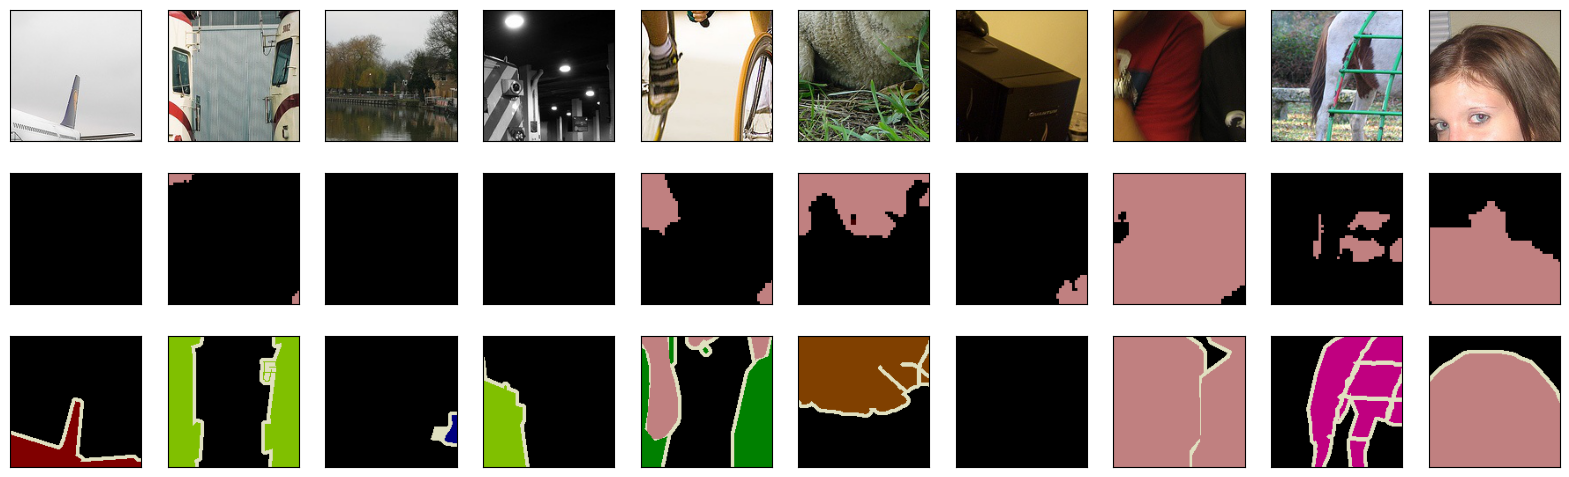

In [29]:
# 开始测试
#---------------测试模型------------
def label2image(pred):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # pred: [320,480]
    colormap = torch.tensor(VOC_COLORMAP,device=device,dtype=int)
    x = pred.long()
    return (colormap[x,:]).data.cpu().numpy()

# 预测前将图像标准化，并转换成(b,c,h,w)的tensor
def predict(img, model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tsf = transforms.Compose([
            transforms.ToTensor(), # 好像会自动转换channel
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    x = tsf(img).unsqueeze(0).to(device) # (3,320,480) -> (1,3,320,480)
    pred = torch.argmax(model(x), dim=1) # 每个通道选择概率最大的那个像素点 -> (1,320,480)
    return pred.reshape(pred.shape[1],pred.shape[2]) # reshape成(320,480)

def evaluate(model:nn.Module):
    model.eval()
    test_images, test_labels = read_voc_images(voc_dir, is_train=False, max_num=10)
    n, imgs = 10, []
    for i in range(n):
        xi, yi = voc_rand_crop(test_images[i], test_labels[i], 150, 150) # Image
        pred = label2image(predict(xi, model))
        imgs += [xi, pred, yi]
    show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n)
    
evaluate(model_ft)